# Random forest regression


This notebook is dedicated to exploring how a random forest regression model is able to predict the absolute value/fold change of the signal for each of the histone marks analysed. The model is trained on the features that were used to define the different types of topologies.

In [2]:
%load_ext autoreload
%autoreload 2
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set_style('ticks')
sns.set(rc={'figure.figsize':(18,9)})
%config InlineBackend.figure_format='retina'

import pickle

import pathlib

import torch

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import r2_score

import shap

import tqdm.auto as tqdm

import chromatinhd as chd

Load slice topologies

In [3]:
working_directory = os.getcwd()
prediction_path = chd.get_output() / "prediction_likelihood/pbmc10k/10k10k/leiden_0.1/v9_128-64-32"
scores_dir = prediction_path / "scoring" / "significant_up"
scores_file = scores_dir / "slicetopologies.csv"
slicetopologies = pd.read_csv(scores_file, index_col = 0)

In [4]:
clusters = ['NK', 'Monocytes', 'CD4 T', 'B', 'CD8 T']
all_slicetopologies_oi = slicetopologies.query("cluster in @clusters")
all_slicetopologies_oi.index.name = "slice_ix"

In [5]:
analysis_folder = prediction_path / "encode_marks"
analysis_folder.mkdir(exist_ok = True, parents = True)

Select the features and targets for the models

In [6]:
features = ['prominence', 'n_subpeaks', 'balances_raw', 'balance', 'dominance',
       'differentialdominance', 'shadow', 'average', 'max', 'average_lfc', 'max_lfc', 'length']

targets = ["DNAme", "H3K27ac", "H3K27me3", "H3K36me3", "H3K4me1", "H3K4me3", "H3K9me3"]

In [1]:
def build_models(input_df, predicted_value, split_group = ""):
    
    # inputs:
    # input_df = dataframe containing the predicted feature for each slice and target 
    # predicted_value = name of the column of the predicted value in input_df
    # split_group = split the train and test data based on: "gene", "cluster" or "cluster_gene"
    
    # outputs:
    # rfr = dictionary of the random forest models for each target
    # r2 = dictionary of the r2 values of the models for each target
    # shapv = dictionary of the shap values of the models for each target (that has r2 > 0.03)
    # shap_subsets = dictionary of the shap subsets of the models for each target (that has r2 > 0.03)
    
    y = {}
    rfr = {}
    r2 = {}
    shapv = {}
    shap_subsets = {}
    
    
    for target in tqdm.tqdm(targets, total = len(targets)):
    
        y[target] = input_df.loc[input_df["target"] == target][predicted_value]
        y[target] = y[target].fillna(y[target].mean())
        X_ = all_slicetopologies_oi.loc[all_slicetopologies_oi.index.isin(input_df.loc[input_df["target"] == target]["slice_ix"])]

        
        # Split the data into training and testing sets
        
        if split_group == "gene": # split by gene id
            
            X = X_[features]
            genes_ = all_slicetopologies_oi["gene_ix"].loc[all_slicetopologies_oi.index.isin(input_df.loc[input_df["target"] == target]["slice_ix"])]
            genes = genes_.values
            # Split the data into training and testing sets
            gss = GroupShuffleSplit(n_splits = 1, test_size=0.2, random_state=42)

            train_indices, test_indices = next(gss.split(X, y[target], groups=genes))

            # Create the train and test sets
            X_train = X.iloc[train_indices].values
            y_train = y[target].iloc[train_indices].values
            X_test = X.iloc[test_indices].values
            y_test = y[target].iloc[test_indices].values

            
        elif split_group == "cluster": # split by cluster
            
            X = X_[features]
            cluster_ = all_slicetopologies_oi["cluster"].loc[all_slicetopologies_oi.index.isin(input_df.loc[input_df["target"] == target]["slice_ix"])]
            cluster = cluster_.values

            # Split the data into training and testing sets
            gss = GroupShuffleSplit(n_splits = 1, test_size=0.2, random_state=42)


            # Split the data into training and testing sets
            train_indices, test_indices = next(gss.split(X, y_abs_c[target], groups=cluster))

            # Create the train and test sets
            X_train = X.iloc[train_indices].values
            y_train = y[target].iloc[train_indices].values
            X_test = X.iloc[test_indices].values
            y_test = y[target].iloc[test_indices].values
            
            
        elif split_group == "cluster_gene": # split by cluster and gene
            
            X = X_[features]
            cluster_gene_ = all_slicetopologies_oi["cluster"].loc[all_slicetopologies_oi.index.isin(input_df.loc[input_df["target"] == target]["slice_ix"])] + '_' + all_slicetopologies_oi["gene"].loc[all_slicetopologies_oi.index.isin(input_df.loc[input_df["target"] == target]["slice_ix"])]
            cluster_gene = cluster_gene_.values

            # Split the data into training and testing sets
            gss = GroupShuffleSplit(n_splits = 1, test_size=0.2, random_state=42)


            # Split the data into training and testing sets
            train_indices, test_indices = next(gss.split(X, y_abs_cg[target], groups=cluster_gene))

            # Create the train and test sets
            X_train = X.iloc[train_indices].values
            y_train = y[target].iloc[train_indices].values
            X_test = X.iloc[test_indices].values
            y_test = y[target].iloc[test_indices].values


    
        else: # random split
            
            X = X_[features].values
            X_train, X_test, y_train, y_test = train_test_split(X, y[target], test_size=0.2, random_state=42)
            

        # Create a random forest regressor
        rfr[target] = RandomForestRegressor(n_estimators=100, random_state=42)

        # Train the model on the full training set
        rfr[target].fit(X_train, y_train)

        # Make predictions on the separate test set
        y_pred = rfr[target].predict(X_test)

        # Evaluate the model's performance on the test set
        r2[target] = r2_score(y_test, y_pred)

        
        if r2[target] > 0.03:
            background_samples = shap.sample(X_train, 100)
            explainer = shap.KernelExplainer(rfr[target].predict, background_samples)
            
            subset_indices = np.random.choice(X_test.shape[0], size=100, replace=False)
            subset_X_test = X_test[subset_indices]
            shap_subsets[target] = subset_X_test

            shap_values = explainer.shap_values(subset_X_test)
            
            shapv[target] = shap_values
        
    # plot r2 and feature importance heatmaps    
    plot_r2_feature_importance(rfr, r2)   
    # plot shap values
    plot_shap(shapv,shap_subsets)
    return rfr,r2, shapv, shap_subsets

In [27]:
def plot_r2_feature_importance(rfr, r2):
    
    fig = plt.figure()
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 12])  

    ax1 = plt.subplot(gs[0])  
    sns.heatmap(pd.DataFrame({"R^2":r2.values()}, index=targets),cmap="viridis", vmin = 0, vmax = 0.2)

    ax2 = plt.subplot(gs[1])  
    f_importance = {}
    f_importance["feature"] = features 
    for target in tqdm.tqdm(targets, total = len(targets)):
        f_importance[target] = rfr[target].feature_importances_
    f_importance = pd.DataFrame(f_importance)
    f_importance = f_importance.set_index("feature")
    sns.heatmap(f_importance.T)
    
    plt.subplots_adjust(wspace=0.4)

    # Show both plots side by side
    plt.show()

In [28]:
def plot_shap(shapv, shapset):
    fig = plt.figure(figsize=[18,9])
    gs = gridspec.GridSpec((len(shapv)+ 1) // 2, 2)
    i = 0
    j=0
    for target in targets:
        if target in shapv_abs:
            if i == 0:
                ax=fig.add_subplot(gs[j, i])
                shap.summary_plot(shapv[target], shapset[target], feature_names = features, plot_size=None, show= False)
                plt.title(target)
                i = 1
            elif i == 1:
                ax=fig.add_subplot(gs[j, i])
                shap.summary_plot(shapv[target], shapset[target], feature_names = features, plot_size=None, show= False)
                plt.title(target)
                i = 0
                j +=1
    plt.tight_layout()
    plt.show()

# Absolute signal

Load the signal slices extracted in the other notebook (3-topology_analysis) and calculate the mean signals.

In [9]:
all_signals_slices = pickle.load((analysis_folder / "all_signals_slices.pkl").open("rb"))

In [10]:
all_signal_topologies = []
for slice_ix, slicetopology in tqdm.tqdm(all_slicetopologies_oi.iterrows(), total = len(all_slicetopologies_oi)):
    signals = all_signals_slices[slice_ix].groupby(level = 0).mean().mean(1)
    all_signal_topologies.append(pd.DataFrame({"slice_ix":slice_ix, "signal":signals.values, "target":signals.index}))
all_signal_topologies = pd.concat(all_signal_topologies)

  0%|          | 0/20942 [00:00<?, ?it/s]

## Models

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

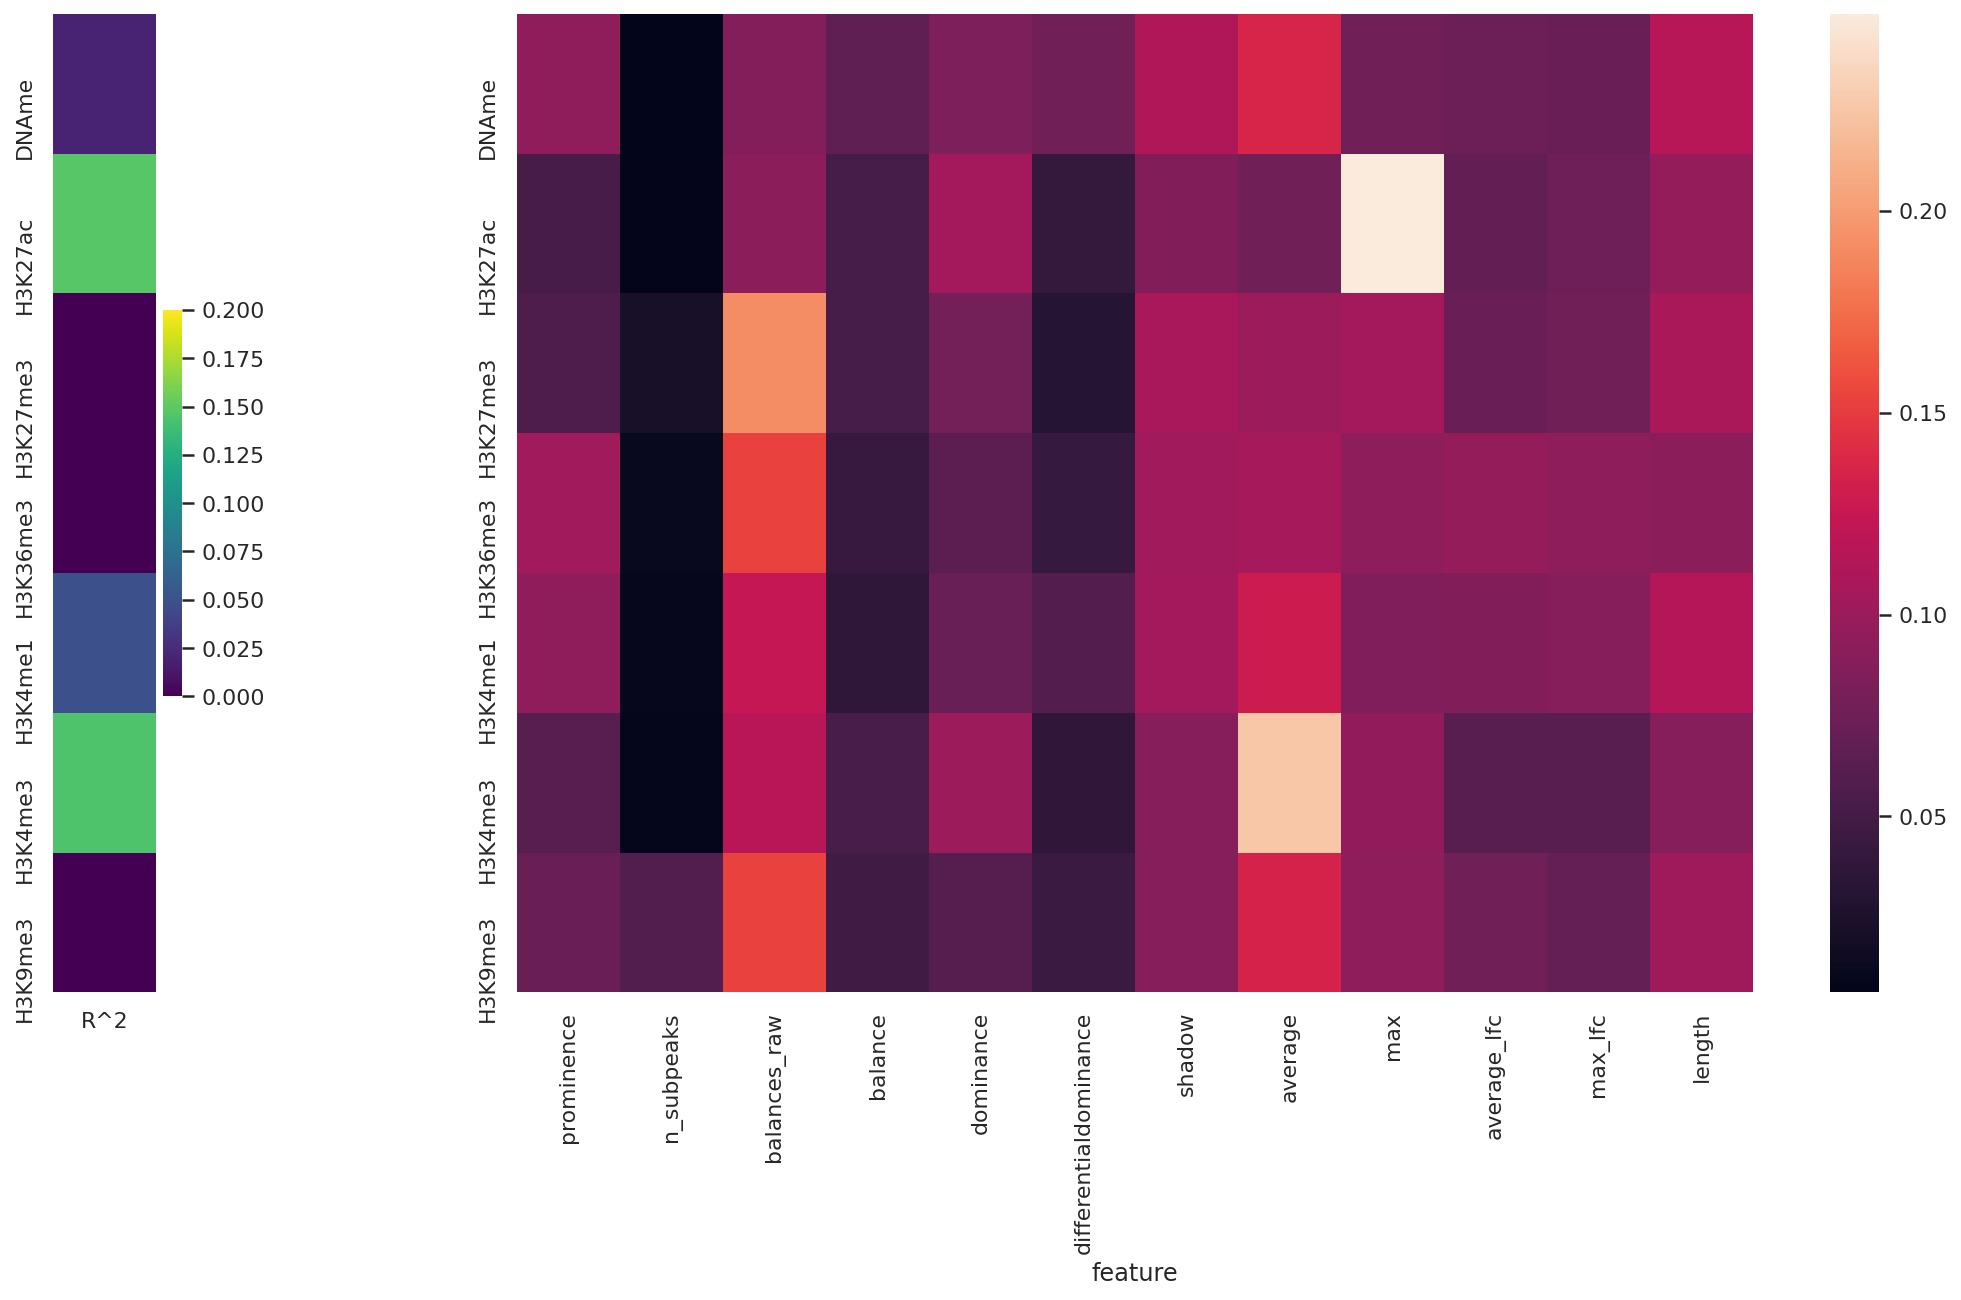

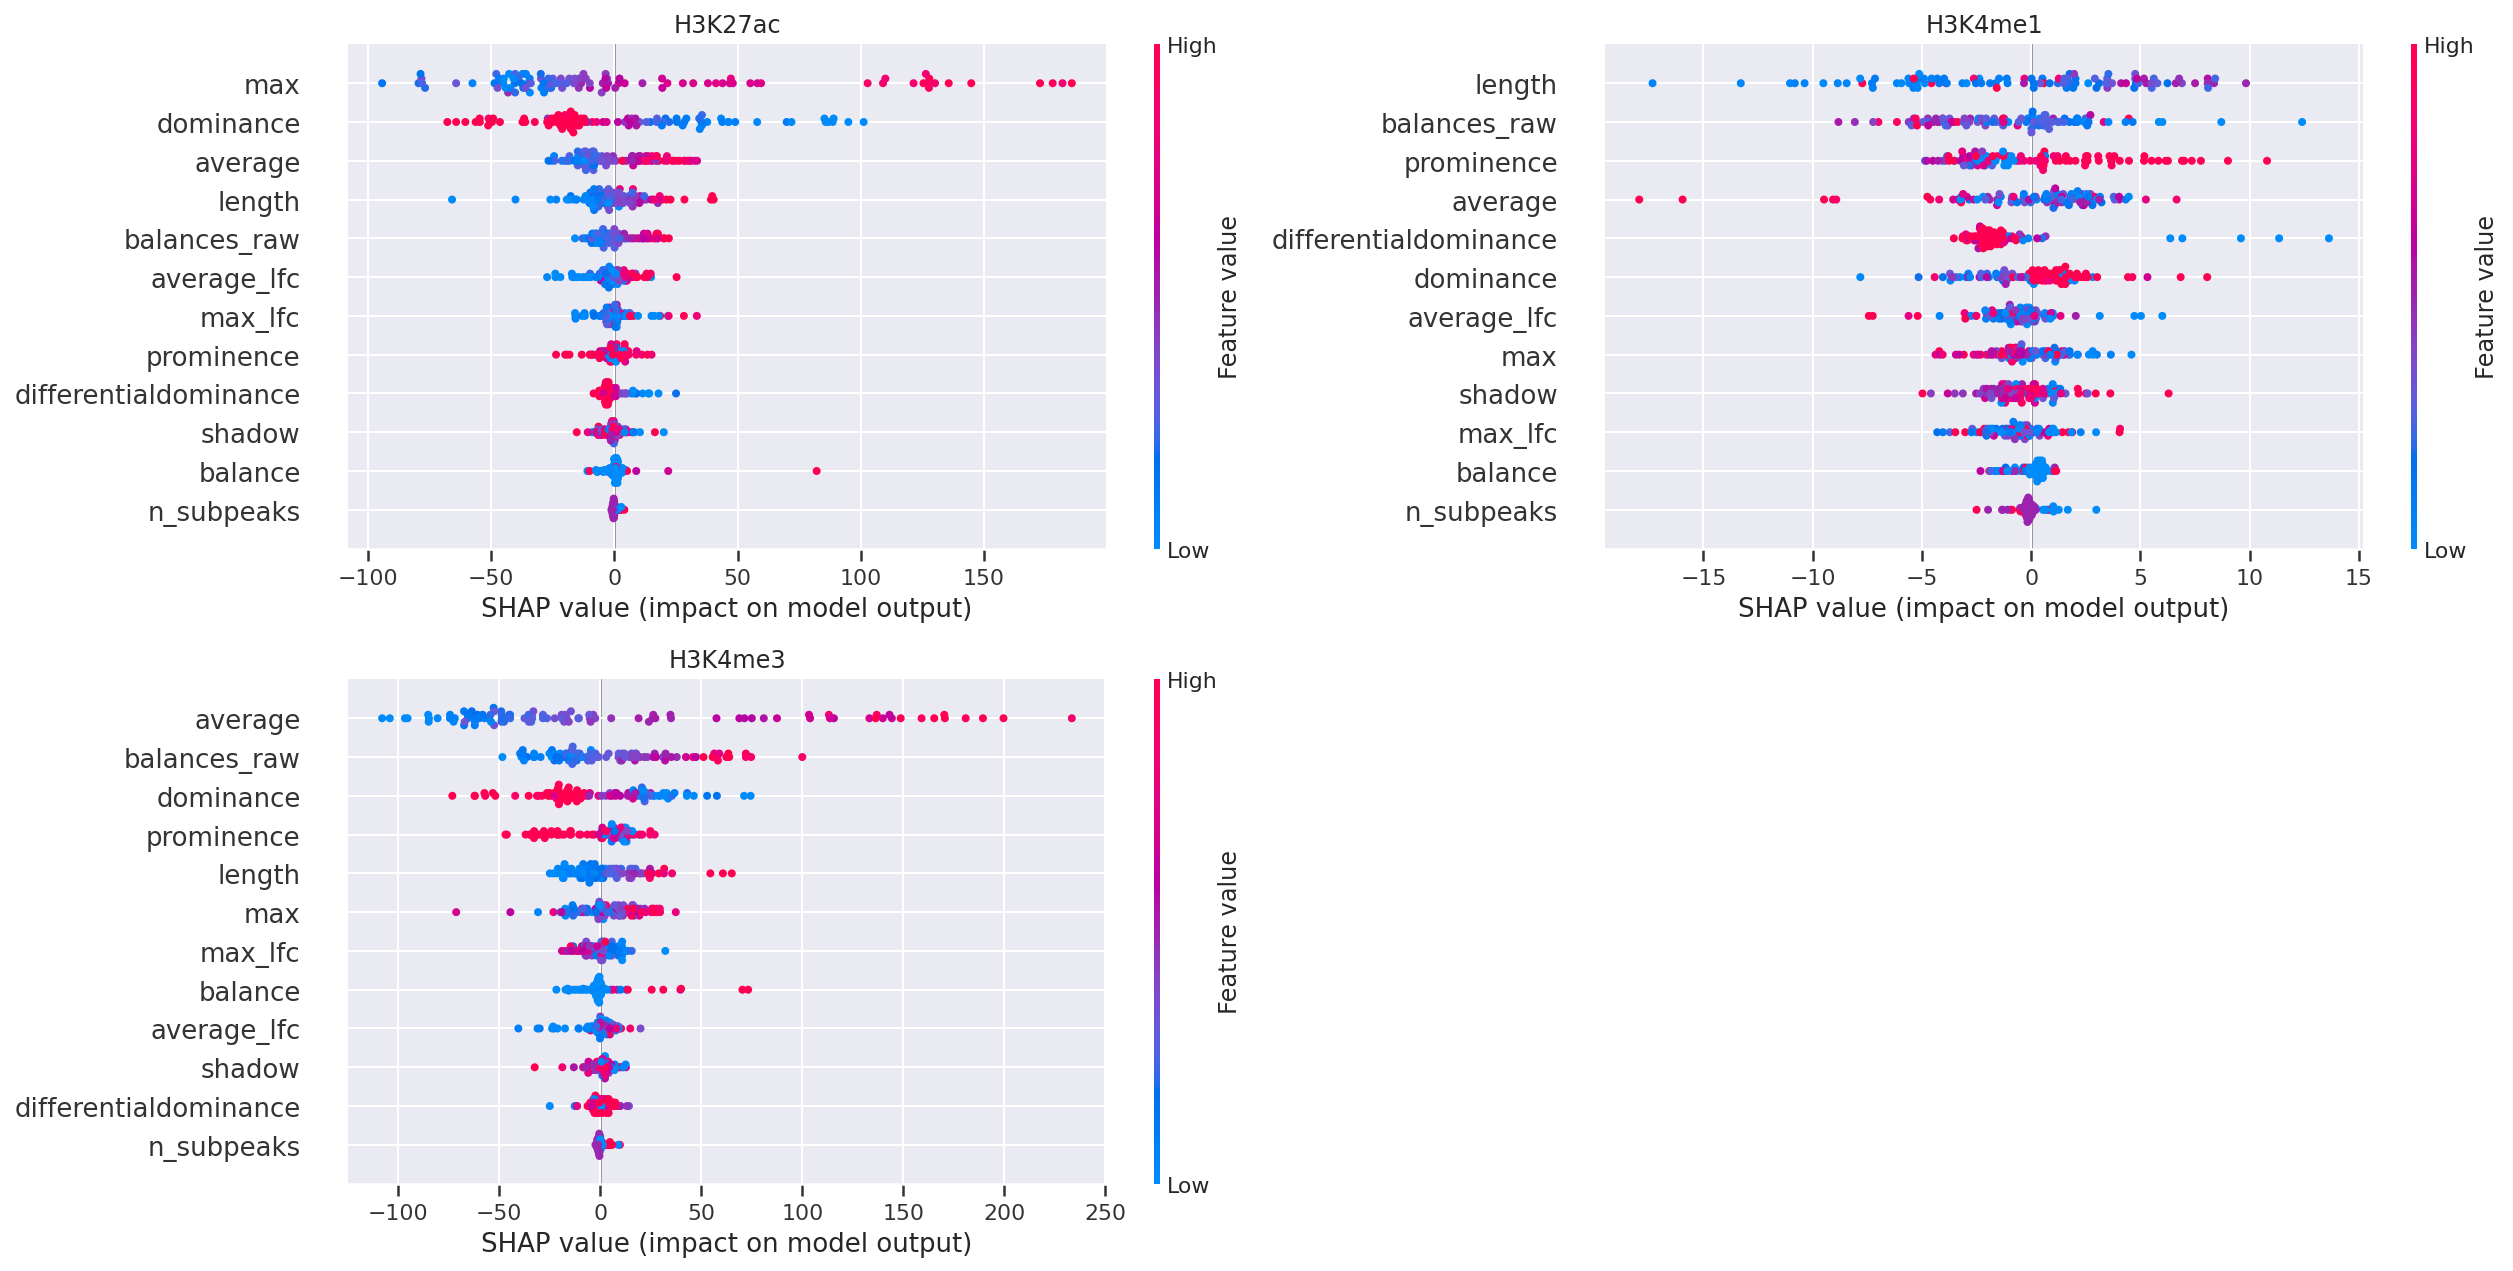

In [30]:
rfr_abs, r2_abs, shapv_abs, shapset_abs = build_models(input_df = all_signal_topologies, predicted_value = "signal", split_group = "")

Plotted above are the r2 values of the random forest regression models; the feature importances of the models; and the shap plots for the models with r2 values > 0.03, which provide information about the direction of the features on the model output. 

If we consider the models with a significant r2 value (H3K27ac, H3K4me1 and H3K4me3), we can observe that although most features are used for the model prediction, some features seem to be more prominent. For example, we see that the max value of a slice is very important in the prediction of the signal value of H3K27ac. This histone is commonly found near gene promoters and enhancer regions, and it plays a crucial role in regulating transcriptional activation. Higher values of differential DNA accessibility are often associated with the presence of H3K27ac, indicating active enhancer regions and active gene expression (https://www.nature.com/articles/nature14590, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5042844/).

Another noteworthy feature is the prominence, which measures how isolated the differential peak is compared to other peaks. This feature seems to have a positive correlation for H3K4me1, and a negative correlation for H3K4me3. This could be explained by the fact that H3K4me1 is associated with enhancer regions and is involved in regulating tissue-specific gene expression and enhancer activity, generally being found at active and poised enhancers. On the other hand, H3K4me3 is involved in promoting an open chromatin structure and facilitating transcriptional initiation. Therefore, it is predominantly associated with gene activation and is enriched near the transcription start sites of actively transcribed genes

## Split by gene

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

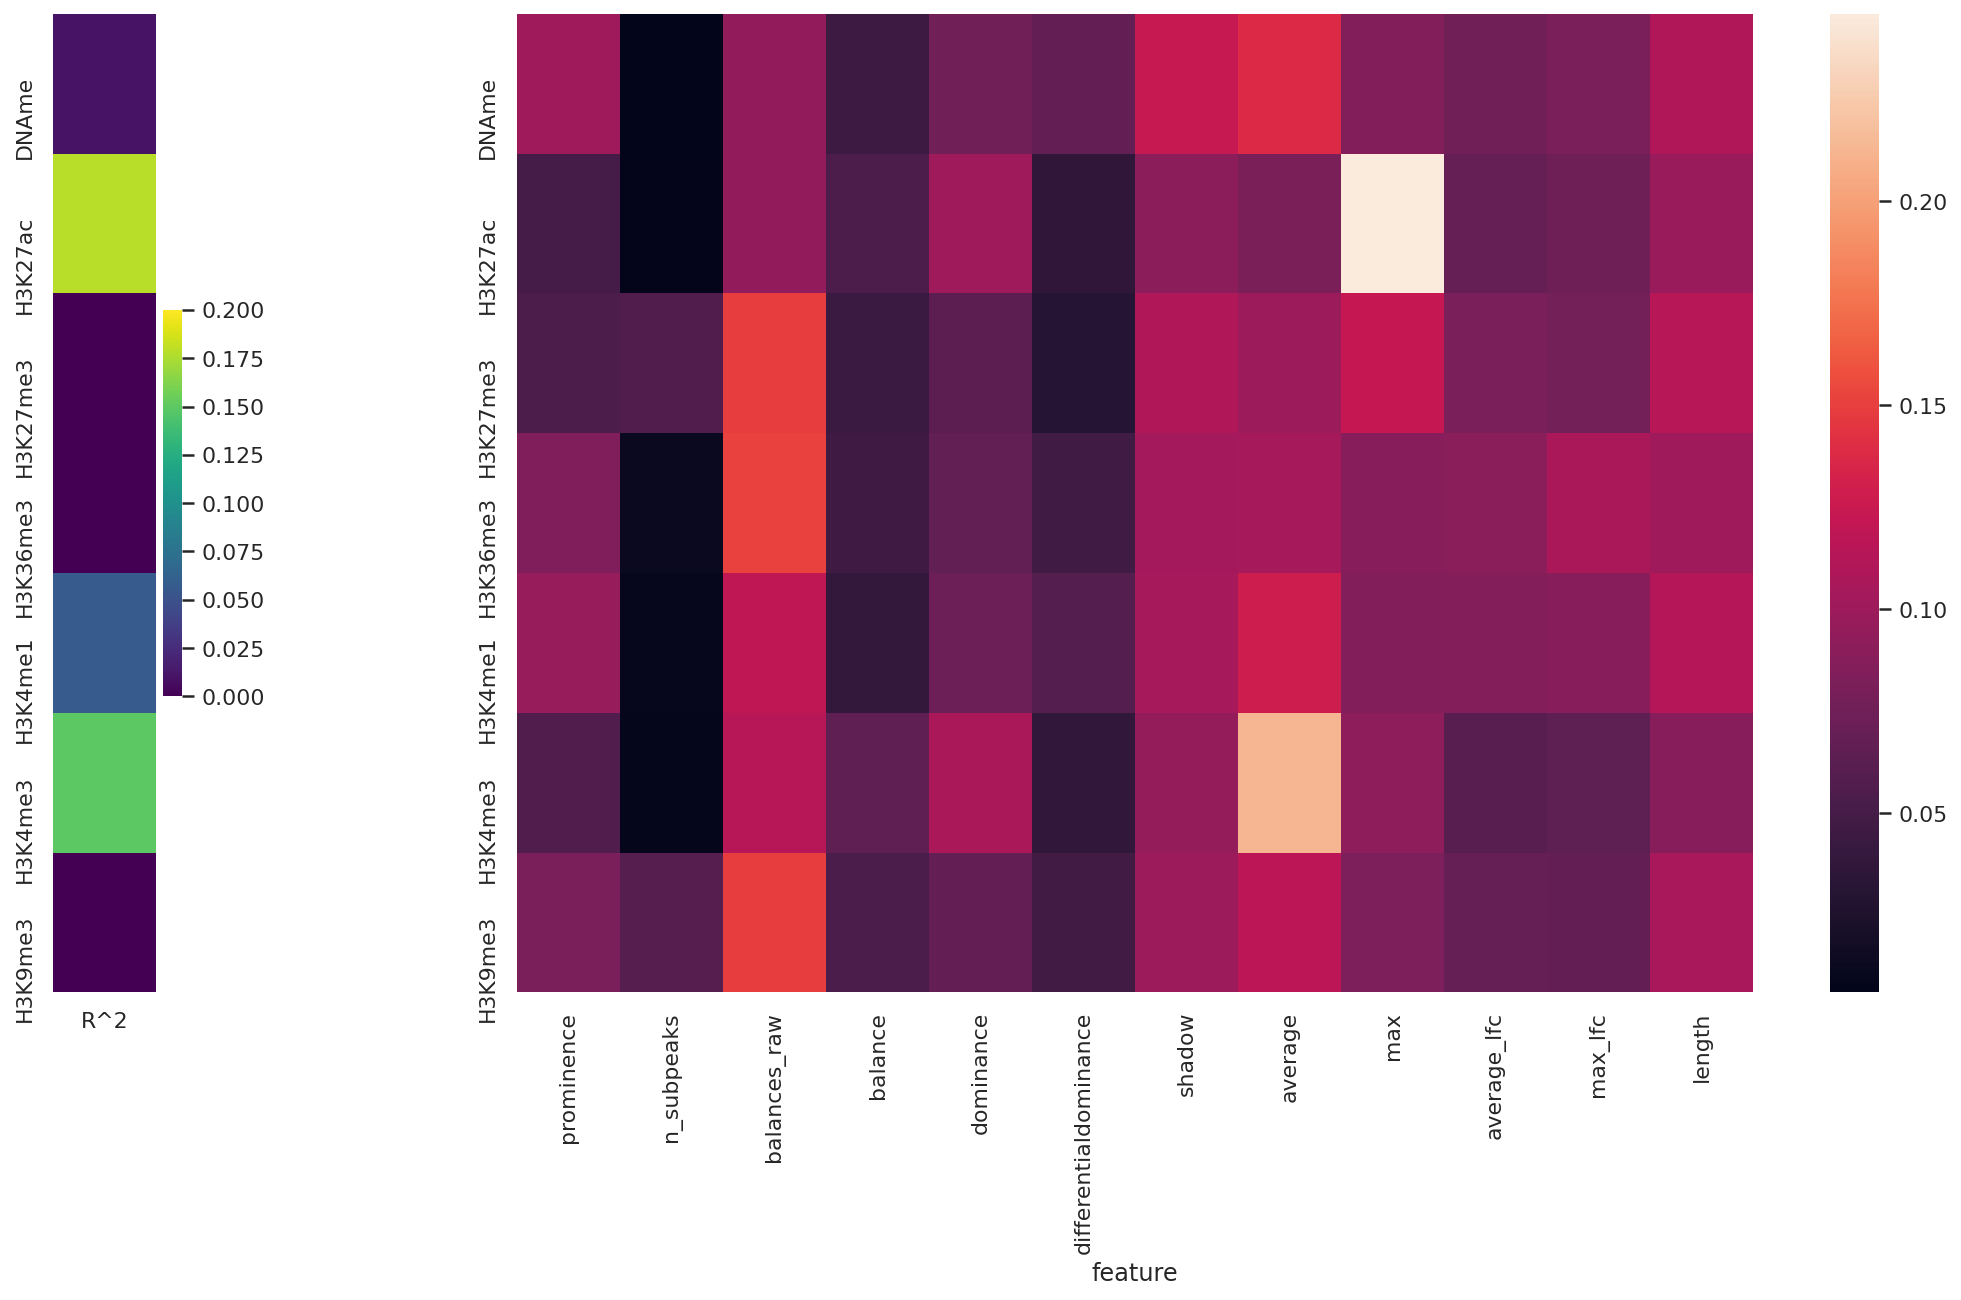

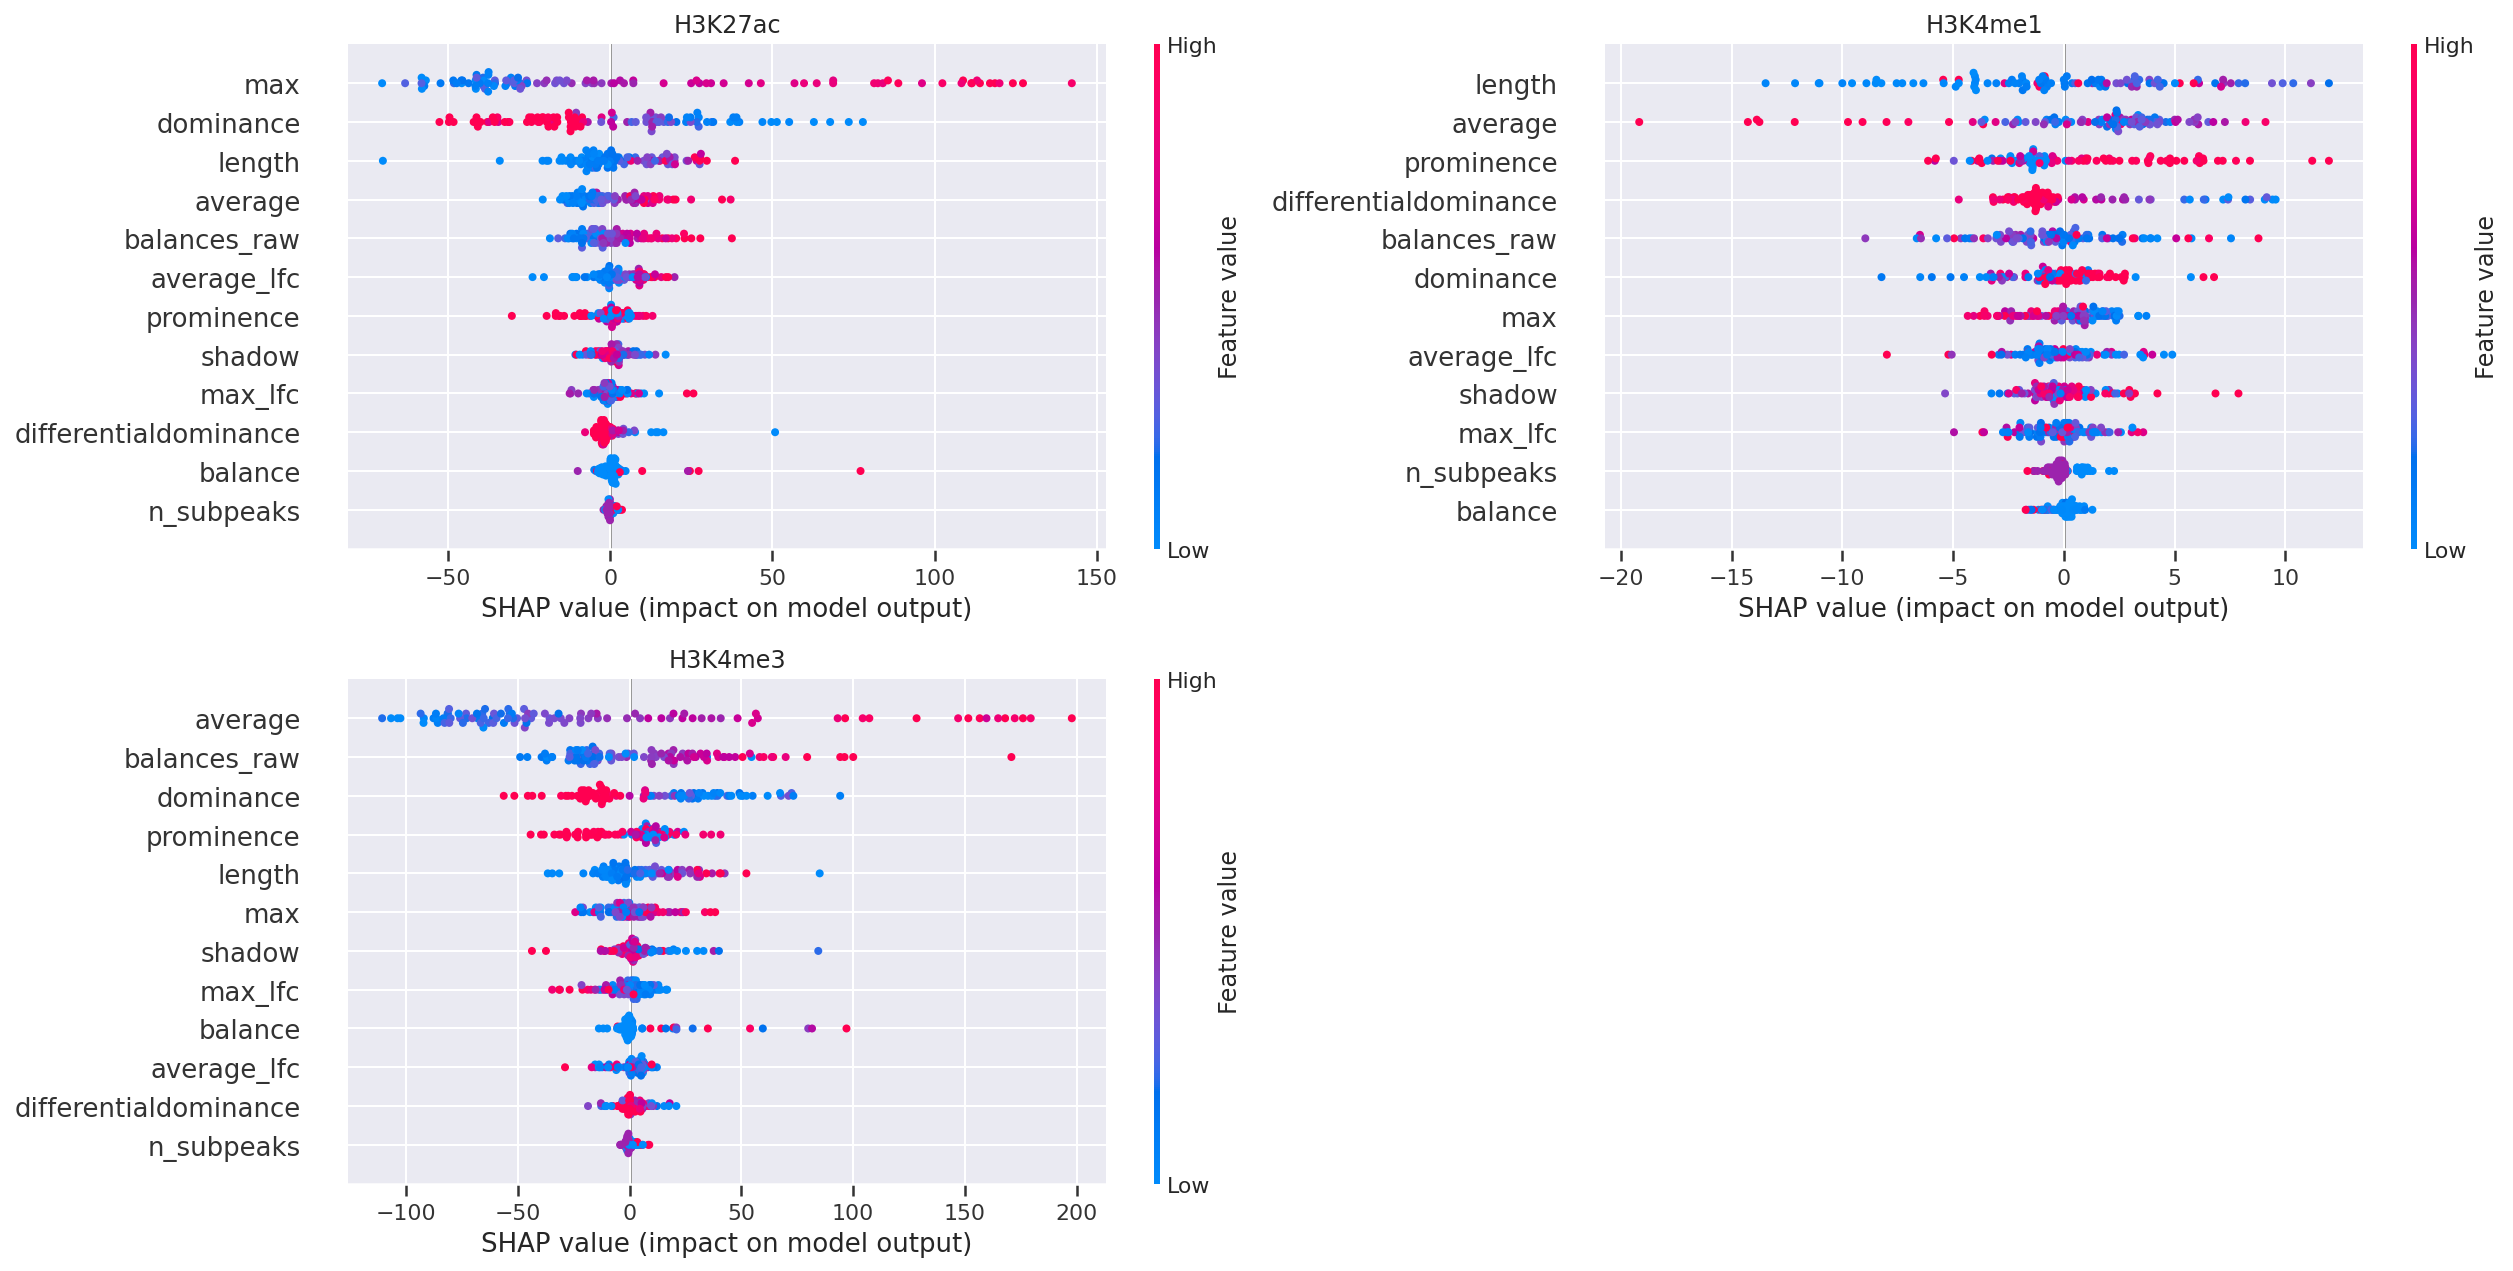

In [31]:
rfr_abs_g, r2_abs_g, shapv_abs_g, shapset_abs_g = build_models(input_df = all_signal_topologies, predicted_value = "signal", split_group = "gene")

Here we produced similar models, but splitting the train and test sets based on gene ids. As we can observe, we obtain very similar results to the model with randomized split. This indicates that the models are generally not biased towards certain genes or groups of genes.

# Fold change

Compute the fold change:

In [32]:
all_signals_slices_ = pickle.load((analysis_folder / "all_signals_slices_.pkl").open("rb"))

In [33]:
# Dictionary of the original cluster where the slice was found
all_og_cluster_dict = all_slicetopologies_oi["cluster"]
all_og_cluster_dict = all_og_cluster_dict.rename("og_cluster")
all_og_cluster_dict = all_og_cluster_dict.to_dict()

In [34]:
all_signal_topologies_ = []
for slice_ix, slicetopology in tqdm.tqdm(all_slicetopologies_oi.iterrows(), total = len(all_slicetopologies_oi)):
    # For each slice, take the average signal of each cell type 
    signals = all_signals_slices_[slice_ix].groupby(["target", "cluster"]).mean().mean(1)
    signals.name = "signal"
    signals = signals.to_frame()
    signals.reset_index(inplace=True)
    
    # (Mask column to calculate fold change)
    signals["is_og_cluster"] = signals["cluster"] == all_og_cluster_dict[slice_ix]
    
    all_signal_topologies_.append(pd.DataFrame({"slice_ix":slice_ix, "signal":signals.signal, "target":signals.target, "cluster": signals.cluster, "is_og_cluster": signals.is_og_cluster}))
all_signal_topologies_ = pd.concat(all_signal_topologies_)

  0%|          | 0/20942 [00:00<?, ?it/s]

In [35]:
# Average signal of the original cell type
all_signal_topologies_og = all_signal_topologies_.loc[all_signal_topologies_["is_og_cluster"]][["slice_ix", "target", "signal"]].set_index(["slice_ix", "target"])
# Average signal in all other cell types
all_signal_topologies_mean_ = all_signal_topologies_.loc[~all_signal_topologies_["is_og_cluster"]][["slice_ix", "target", "signal"]].groupby(["slice_ix", "target"]).mean()

# Calculate fold change, apply log (not good for DNAme)
all_signal_topologies_fold_change = all_signal_topologies_og.join(all_signal_topologies_mean_, lsuffix='_og', rsuffix="_mean")
all_signal_topologies_fold_change["fc"] = all_signal_topologies_fold_change["signal_og"]/all_signal_topologies_fold_change["signal_mean"]
all_signal_topologies_fold_change["log_fc"] = np.log(all_signal_topologies_fold_change["fc"])
all_signal_topologies_fold_change.reset_index(inplace=True)
all_signal_topologies_fold_change.replace([np.inf, -np.inf], np.nan, inplace=True)

divide by zero encountered in log


## Models

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

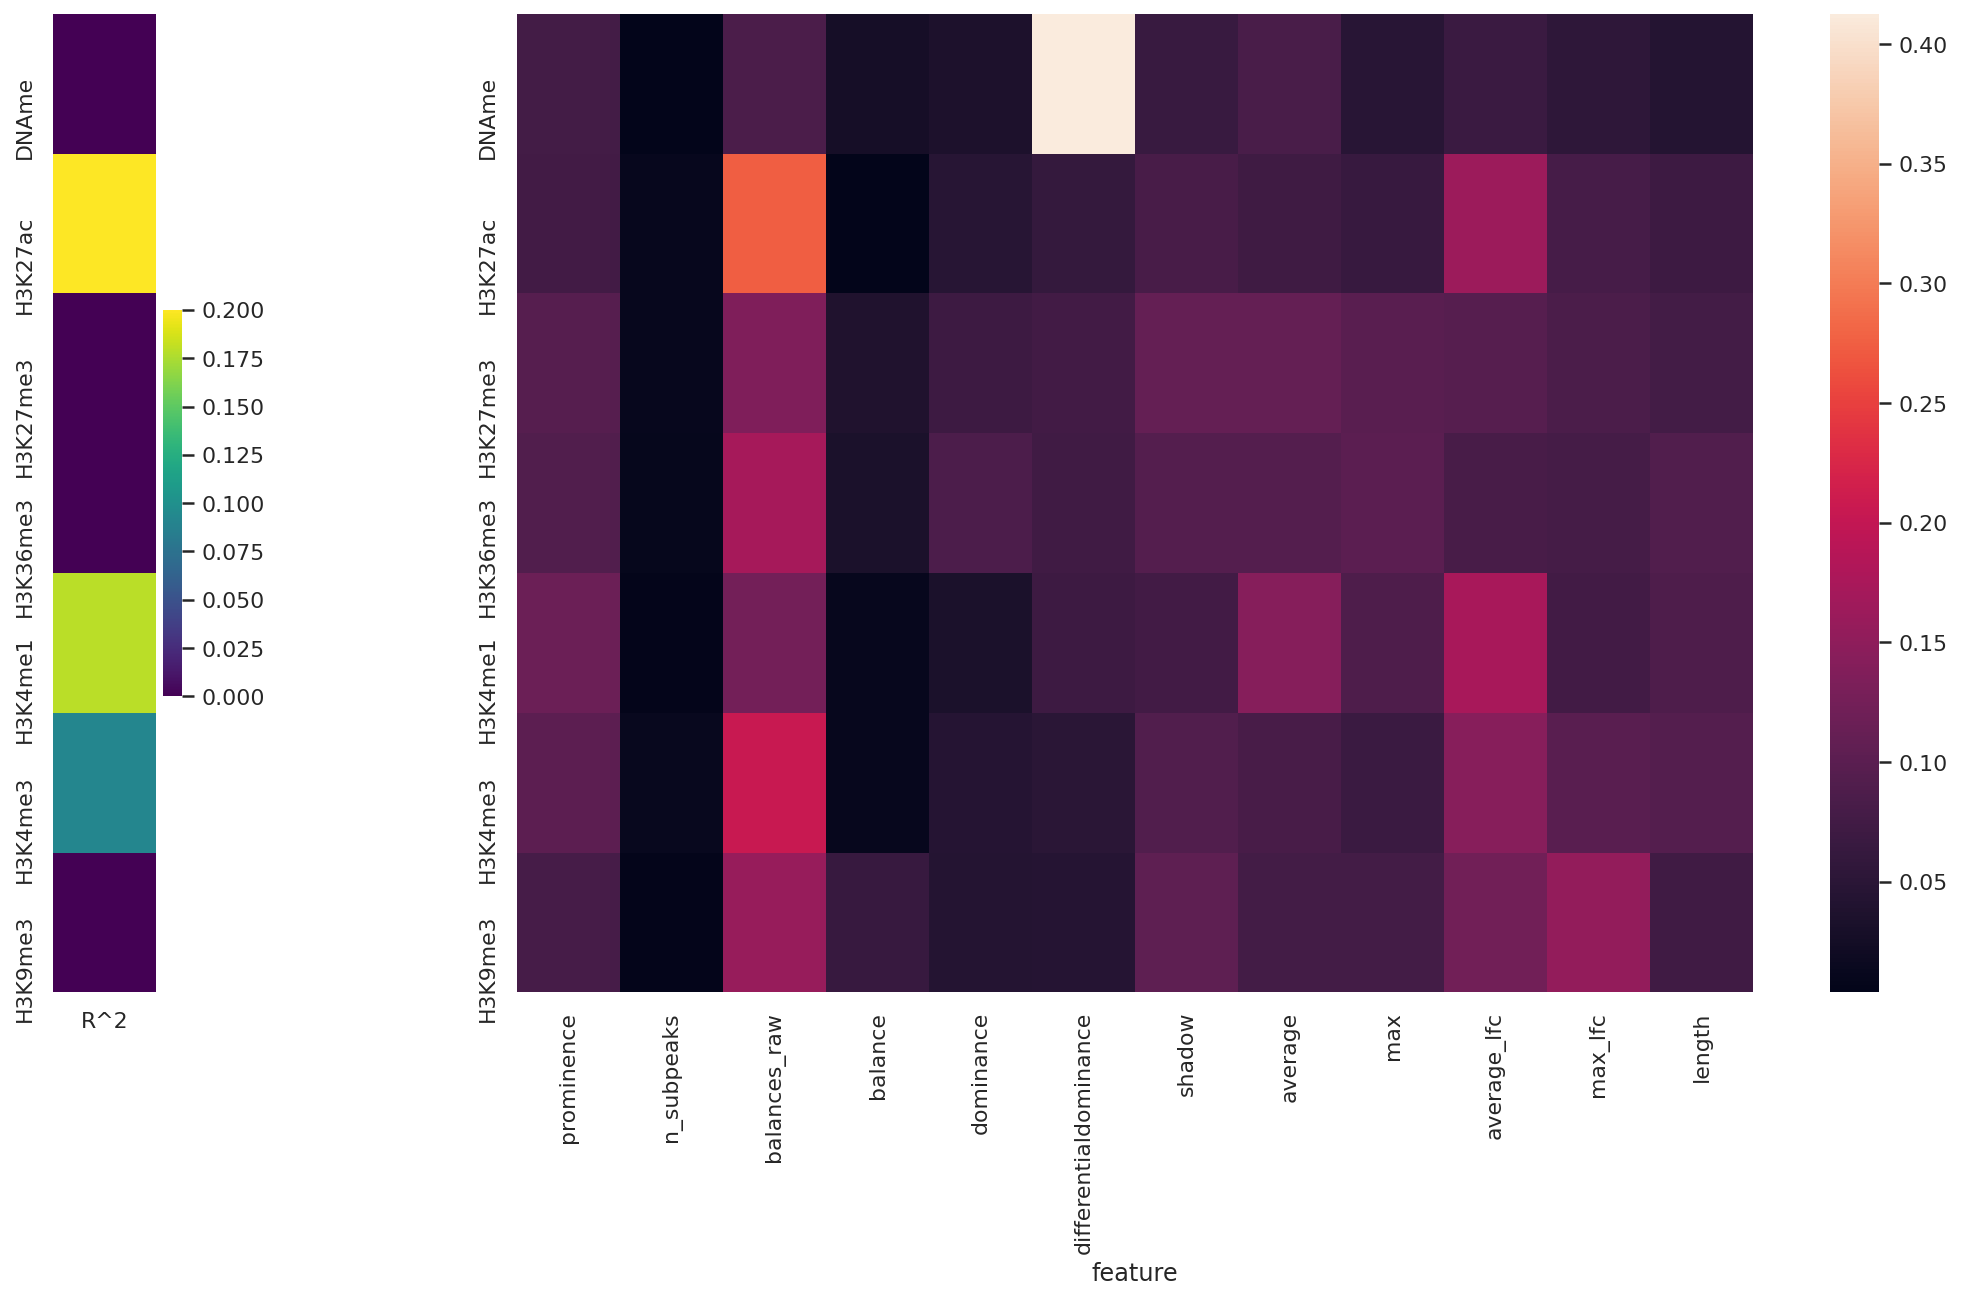

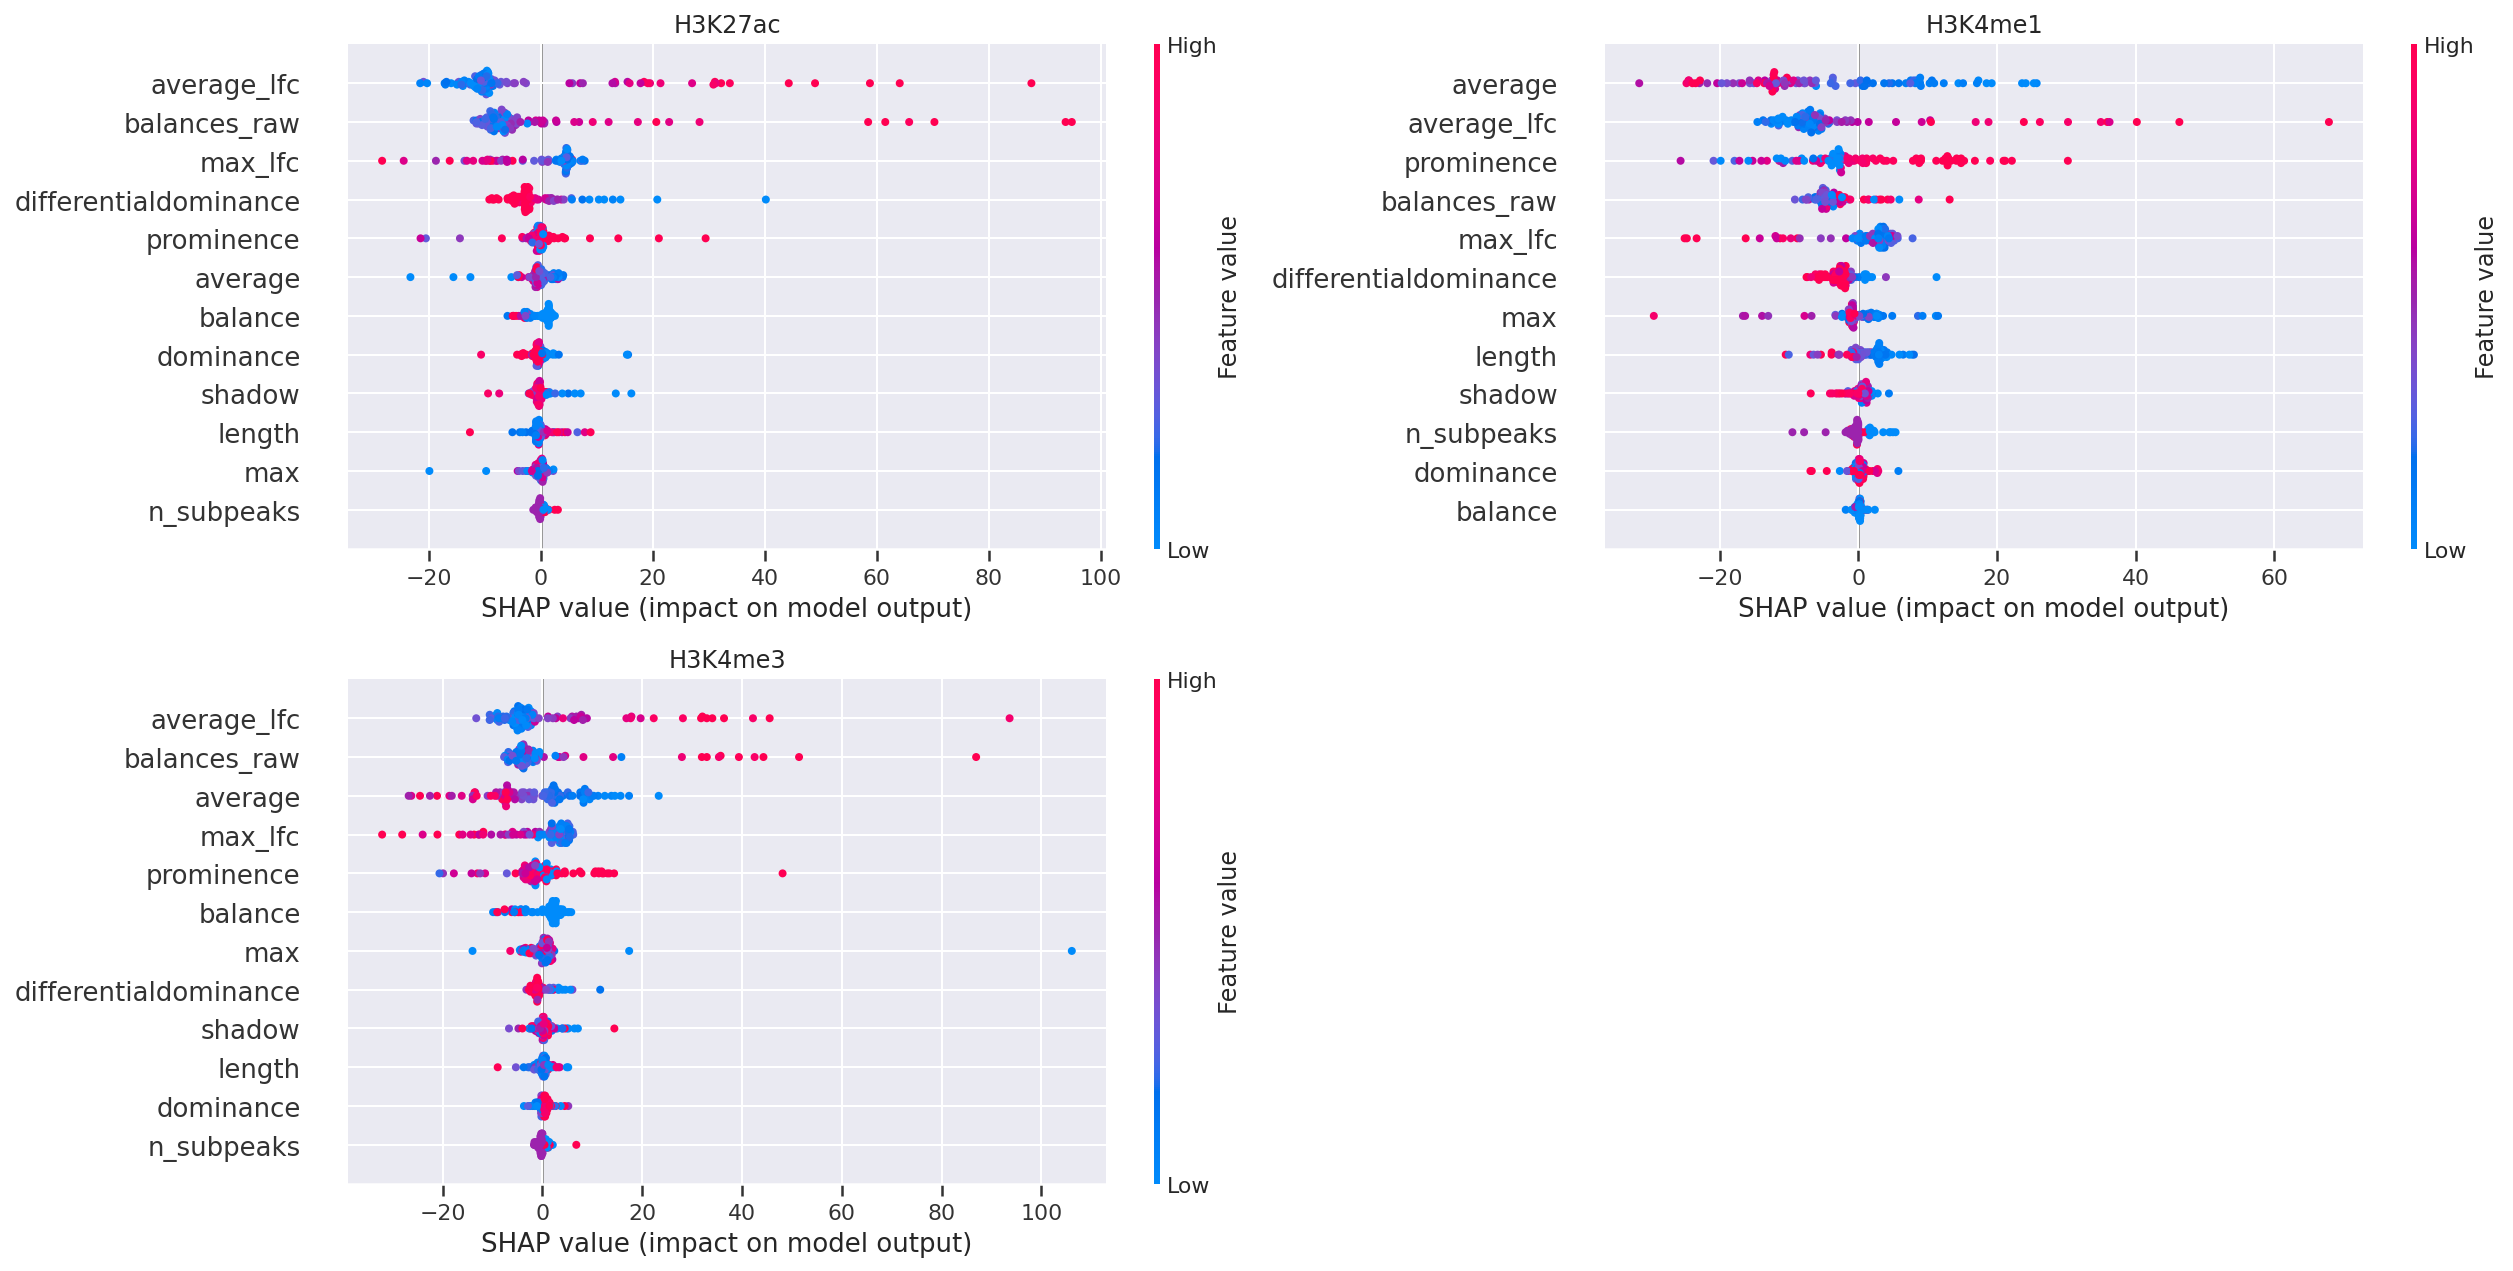

In [36]:
rfr_fc, r2_fc, shapv_fc, shapset_fc = build_models(input_df = all_signal_topologies_fold_change, predicted_value = "fc")

Here we have another set of random forest regression models for the prediction of the fold change values instead of the absolute values. Once again, we see that the r2 values seem to be significant only for H3K27ac, H3K4me1 and H3K4me3. However, as we could expect, we find that different features seem to be more important for the prediction of the fold change. Namely, we observe that the average_lfc and the balances_raw play a big role in the determination of the output.

## Split by gene

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

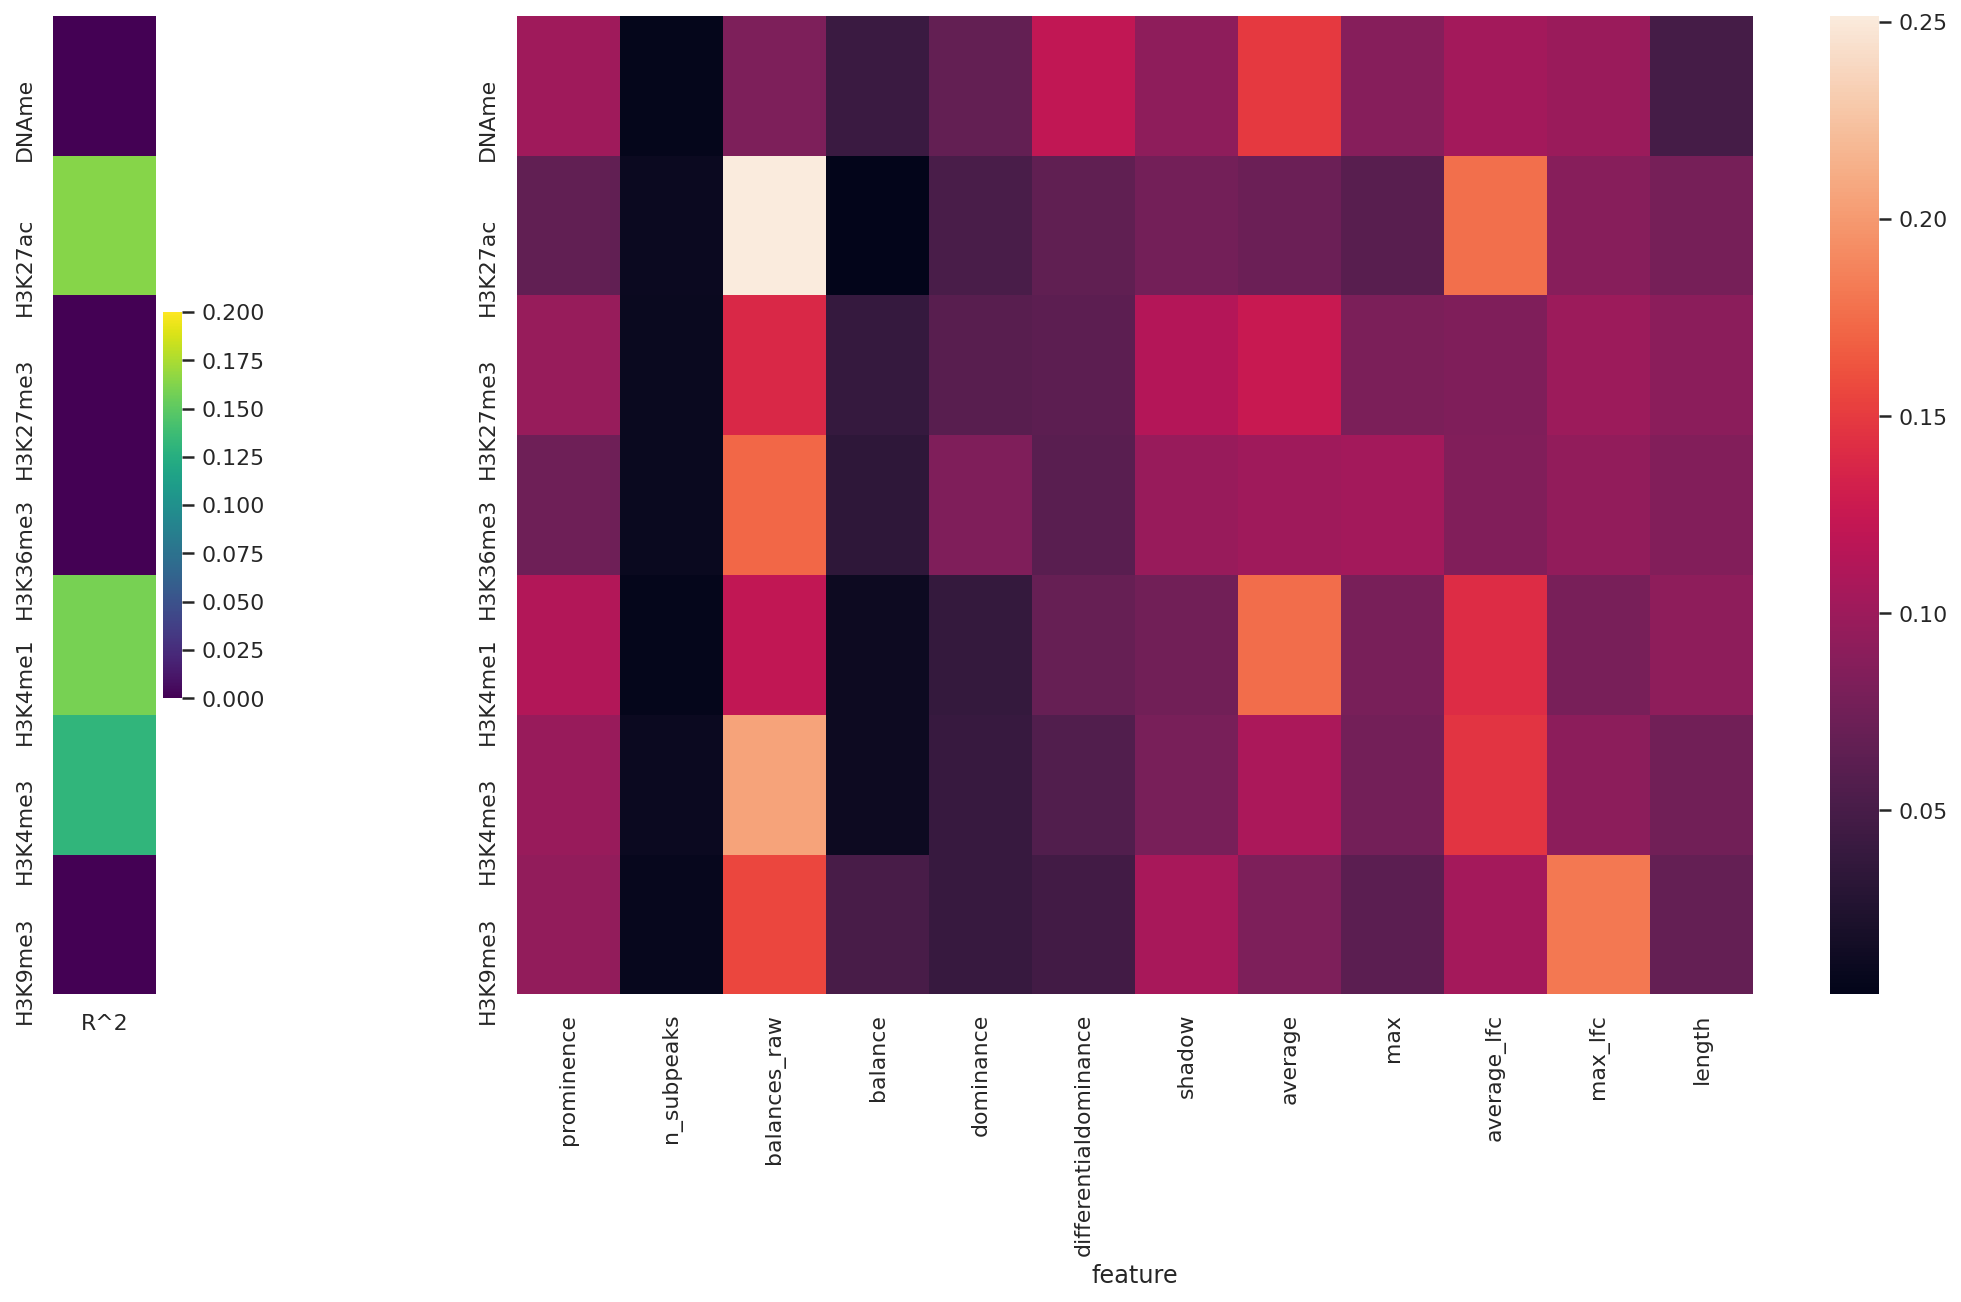

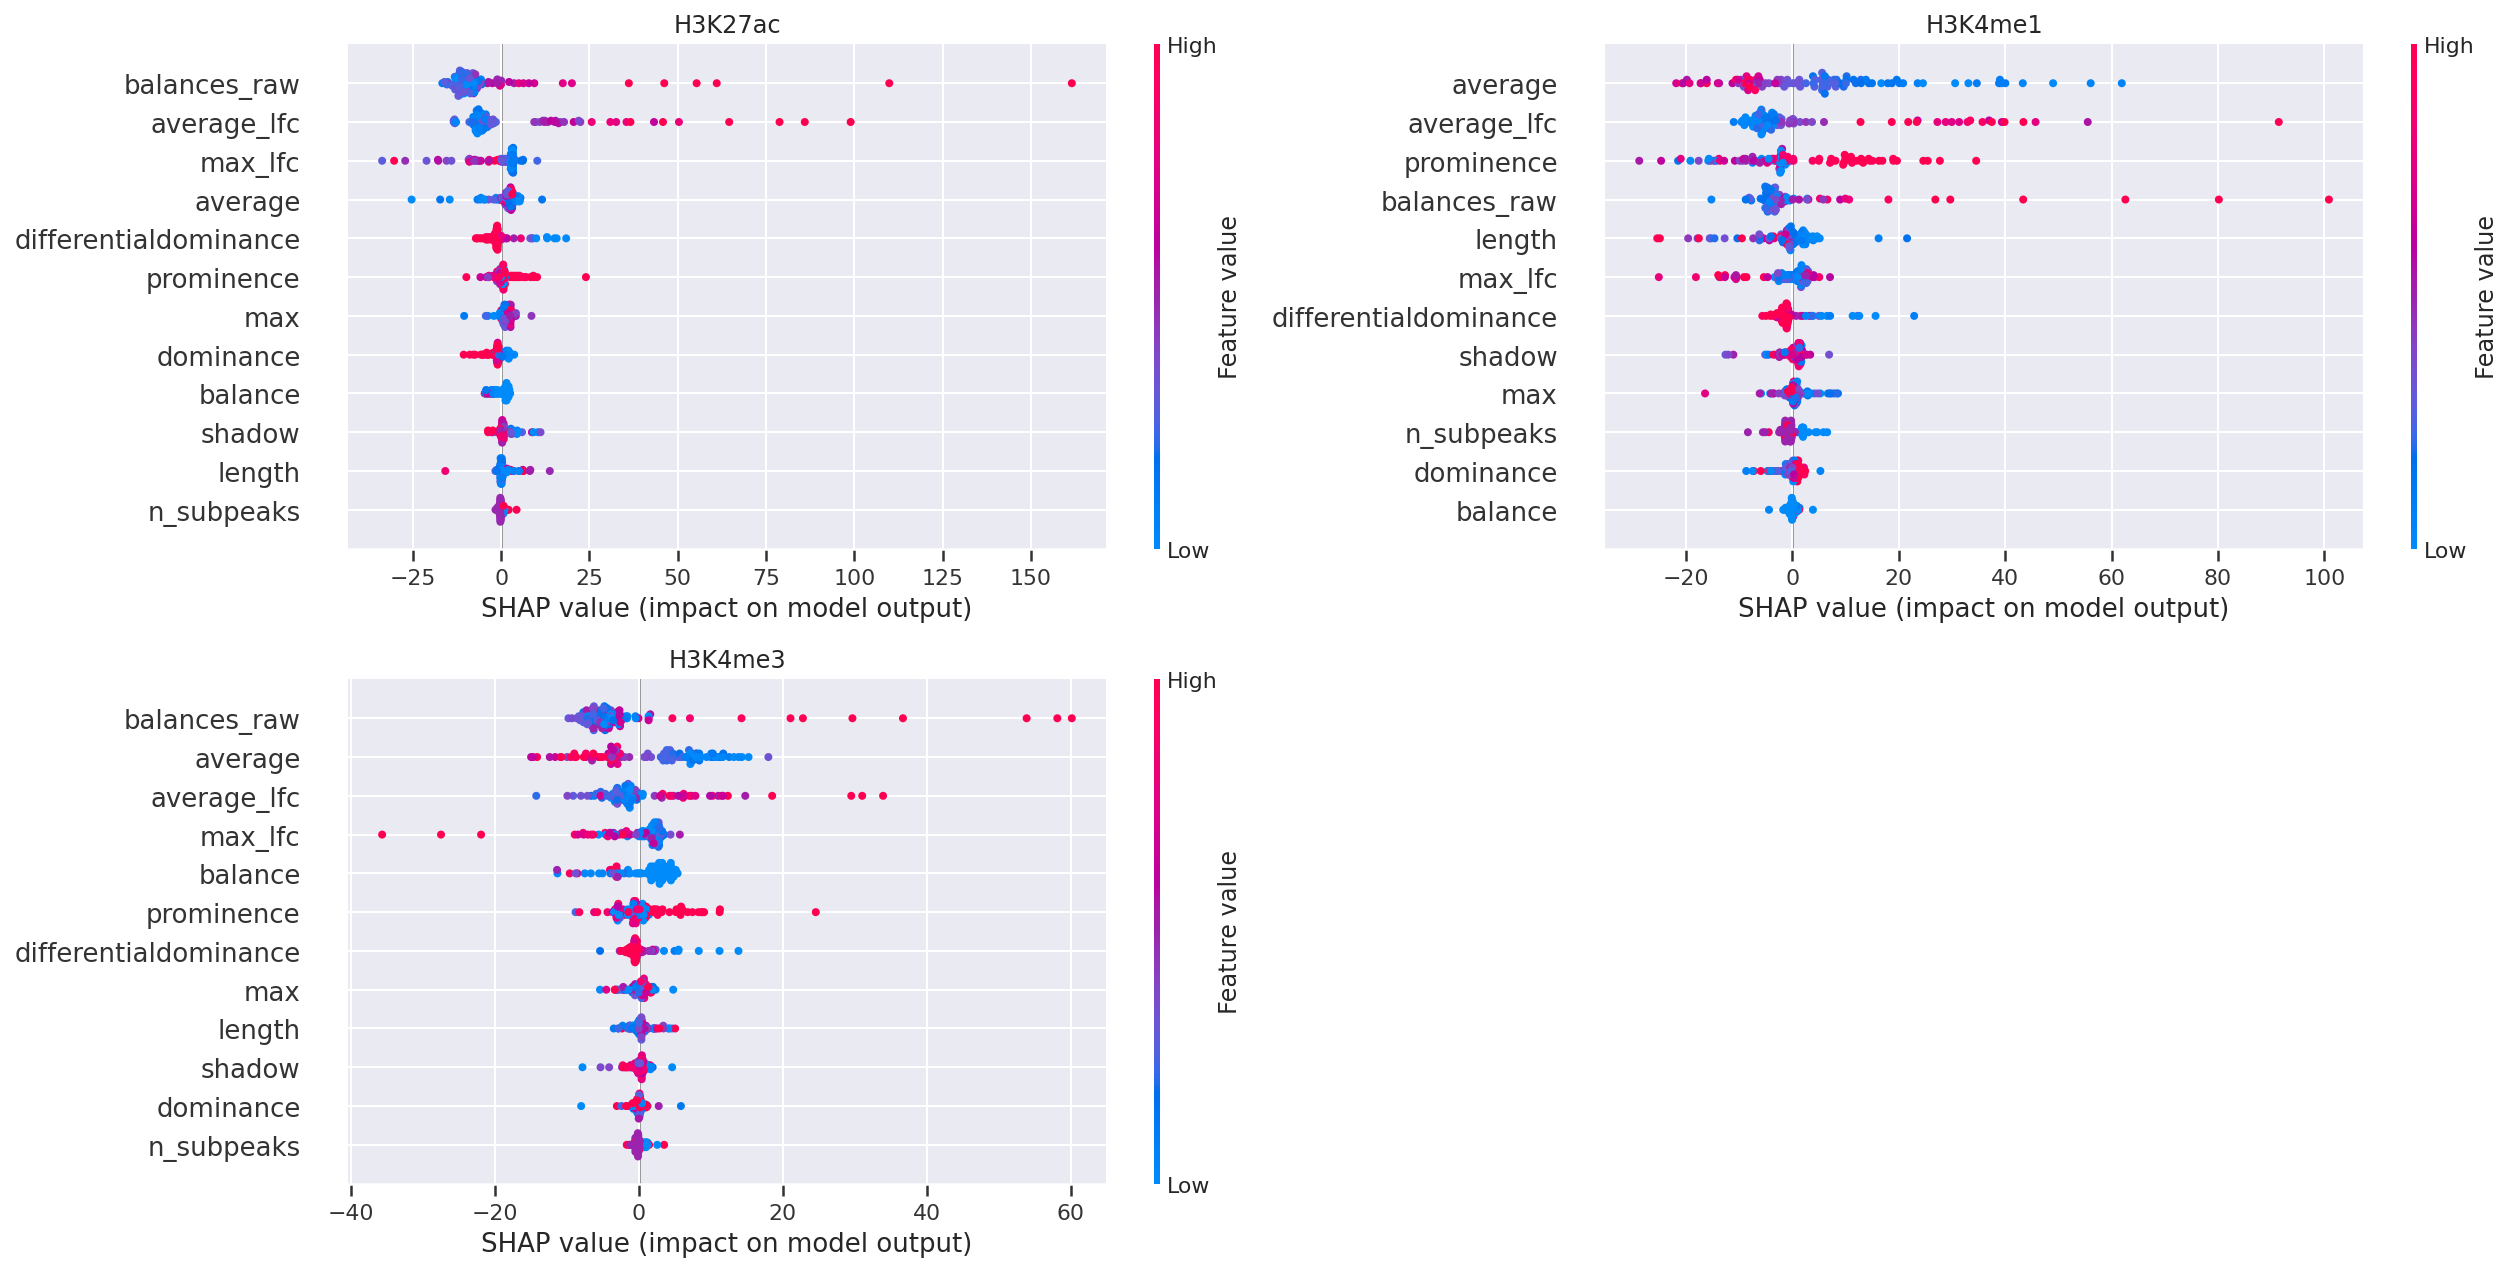

In [37]:
rfr_fc_g, r2_fc_g, shapv_fc_g, shapset_fc_g = build_models(input_df = all_signal_topologies_fold_change, predicted_value = "fc", split_group="gene")

Once again, we produced similar models by splitting the train and test sets based on genes, and found very similar results to the randomized split models.

### Pickle

Code to pickle the models and their r2 and shap values.

#### Absolute signal

In [11]:
rfr_abs_path = os.path.join(working_directory, "rfr_abs.pkl")
r2_abs_path = os.path.join(working_directory, "r2_abs.pkl")
shapv_abs_path = os.path.join(working_directory, "shapv_abs.pkl")
shapset_abs_path = os.path.join(working_directory, "shapset_abs.pkl")

Dump

In [28]:
with open(rfr_abs_path, 'wb') as file:
    pickle.dump(rfr_abs, file)
    
with open(r2_abs_path, 'wb') as file:
    pickle.dump(r2_abs, file)

with open(shapv_abs_path, 'wb') as file:
    pickle.dump(shapv_abs, file)
    
with open(shapset_abs_path, 'wb') as file:
    pickle.dump(shapset_abs, file)

Load

In [12]:
with open(rfr_abs_path, 'rb') as file:
    rfr_abs = pickle.load(file)
    
with open(r2_abs_path, 'rb') as file:
    r2_abs = pickle.load(file)

with open(shapv_abs_path, 'rb') as file:
    shapv_abs = pickle.load(file)
    
with open(shapset_abs_path, 'rb') as file:
    shapset_abs = pickle.load(file)

#### Absolute signal split by gene

In [33]:
rfr_abs_g_path = os.path.join(working_directory, "rfr_abs_g.pkl")
r2_abs_g_path = os.path.join(working_directory, "r2_abs_g.pkl")
shapv_abs_g_path = os.path.join(working_directory, "shapv_abs_g.pkl")
shapset_abs_g_path = os.path.join(working_directory, "shapset_abs_g.pkl")

Dump

In [34]:
with open(rfr_abs_g_path, 'wb') as file:
    pickle.dump(rfr_abs_g, file)
    
with open(r2_abs_g_path, 'wb') as file:
    pickle.dump(r2_abs_g, file)
    
with open(shapv_abs_g_path, 'wb') as file:
    pickle.dump(shapv_abs_g, file)
    
with open(shapset_abs_g_path, 'wb') as file:
    pickle.dump(shapset_abs_g, file)

Load

In [35]:
with open(rfr_abs_g_path, 'rb') as file:
    rfr_abs_g = pickle.load(file)
    
with open(r2_abs_g_path, 'rb') as file:
    r2_abs_g = pickle.load(file)

with open(shapv_abs_g_path, 'rb') as file:
    shapv_abs_g = pickle.load(file)
    
with open(shapset_abs_g_path, 'rb') as file:
    shapset_abs_g = pickle.load(file)

#### Fold change

In [16]:
rfr_fc_path = os.path.join(working_directory, "rfr_fc.pkl")
r2_fc_path = os.path.join(working_directory, "r2_fc.pkl")
shapv_fc_path = os.path.join(working_directory, "shapv_fc.pkl")
shapset_fc_path = os.path.join(working_directory, "shapset_fc.pkl")

Dump

In [17]:
with open(rfr_fc_path, 'wb') as file:
    pickle.dump(rfr_fc, file)
    
with open(r2_fc_path, 'wb') as file:
    pickle.dump(r2_fc, file)

with open(shapv_fc_path, 'wb') as file:
    pickle.dump(shapv_fc, file)
    
with open(shapset_fc_path, 'wb') as file:
    pickle.dump(shapset_fc, file)

Load

In [9]:
with open(rfr_fc_path, 'rb') as file:
    rfr_fc = pickle.load(file)
    
with open(r2_fc_path, 'rb') as file:
    r2_fc = pickle.load(file)

with open(shapv_fc_path, 'rb') as file:
    shapv_fc = pickle.load(file)
    
with open(shapset_fc_path, 'rb') as file:
    shapset_fc = pickle.load(file)

#### Fold change split by gene

In [13]:
rfr_fc_g_path = os.path.join(working_directory, "rfr_fc_g.pkl")
r2_fc_g_path = os.path.join(working_directory, "r2_fc_g.pkl")
shapv_fc_g_path = os.path.join(working_directory, "shapv_fc_g.pkl")
shapset_fc_g_path = os.path.join(working_directory, "shapset_fc_g.pkl")

Dump

In [14]:
with open(rfr_fc_g_path, 'wb') as file:
    pickle.dump(rfr_fc_g, file)
    
with open(r2_fc_g_path, 'wb') as file:
    pickle.dump(r2_fc_g, file)

with open(shapv_fc_g_path, 'wb') as file:
    pickle.dump(shapv_fc_g, file)
    
with open(shapset_fc_g_path, 'wb') as file:
    pickle.dump(shapset_fc_g, file)

Load

In [56]:
with open(rfr_fc_g_path, 'rb') as file:
    rfr_fc_g = pickle.load(file)
    
with open(r2_fc_g_path, 'rb') as file:
    r2_fc_g = pickle.load(file)

with open(shapv_fc_g_path, 'rb') as file:
    shapv_fc_g = pickle.load(file)
    
with open(shapset_fc_g_path, 'rb') as file:
    shapset_fc_g = pickle.load(file)